# Generování textu znakovou RNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tqdm

import torch
import torch.nn.functional as F
from torch import nn

import ans

d:\users\lexik\anaconda3\envs\ans2\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
d:\users\lexik\anaconda3\envs\ans2\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
d:\users\lexik\anaconda3\envs\ans2\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


V tomto cvičení nebudeme používat GPU, protože budeme zpracovávat znaky po jednom a v takto malých dávkách overhead způsobený neustálými přesuny dat mezi GPU a RAM výpočty pouze zpomalí.

# Data

Namísto obrazu tentokrát použijeme textová data. Konkrétně se jedná o novinové nadpisy, které se budeme snažit generovat automaticky. Všechna data jsou v jediném souboru `data/headlines.txt`.

Z textu byly odstraněny háčky, čárky a všechny nestandardní znaky. Není tedy potřeba řešit kódování apod.

In [2]:
data = open('data/articles_idnes.txt').read()
lines = [line for line in data.split('\n') if line]

Ukázka dat:

In [3]:
for i in range(10):
    print(i, random.choice(lines))

0 klobouk dolu chvalil utocnika docekala jablonecky trener rada
1 zemedelci hudruji kvuli foceni v jeteli obcas je zmate fotomontaz
2 konecne dostihova sezona na karlovarskem zavodisti zacina
3 po bruselu uz jen tricitkou ze silnic budou pesi zony
4 spocitejte si sve vibracni cislo a dozvite se co vas letos jeste ceka
5 sokolov vzdava druhou ligu majitele skonci s profesionalnim fotbalem
6 na vikend se ochladi v nedeli muze prset po celem cesku
7 nekajte se zbytecne 8 situaci kdy jsou omluvy na obtiz
8 nejvetsi brodsky hotel omezil provoz chysta se demolice spekuluje se
9 indicky horoskop lasky jaka jste v sexu a vztahu


Sada znaků = náš slovník:

In [4]:
chars = list(sorted(set(data)))
print(len(chars), chars)

38 ['\n', ' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Všimněme si, že první znak je `'\n'`. Ten použijeme jako stop znak, neboli speciální token, jenž bude označovat konec sekvence. Pokud tedy při postupném generování věty dojde na tento znak, proces zastavíme.

Následující tabulka (`dict`) nám usnadní převod znaku na index.

In [5]:
chr2idx = {c: i for i, c in enumerate(chars)}

Podíváme se na statistické rozložení prvních znaků ve větách.

In [6]:
counts = {c: 0 for c in chars}
for line in lines:
    counts[line[0]] += 1
counts = np.array([counts[c] for c in chars], dtype=np.float)
p0 = counts / counts.sum()

d:\users\lexik\anaconda3\envs\ans2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


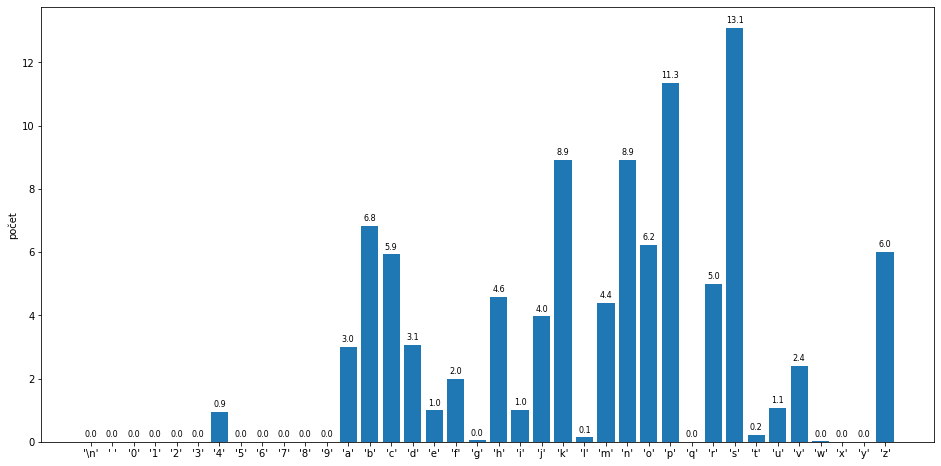

In [7]:
plt.figure(figsize=(16, 8))
rects = plt.bar(range(len(chars)), 100. * p0)
plt.xticks(range(len(chars)), ['{}'.format(repr(c)) for c in chars])
for r in rects:
    x, w, h = r.get_x(), r.get_width(), r.get_height()
    plt.text(x + w / 2., h + 0.1, '{:.1f}'.format(h), ha='center', va='bottom', fontsize=8)
plt.ylabel('počet');

# Sekvenční data a PyTorch

## Embedding

Následující funkce `str2idt` převede řetězec na sekvenci čísel (index tensor) odpovídajících indexům znaků v tabulce. Pokud např. bude celý náš "slovník" `chars = ['a', 'b', 'c']`, pak funkce `str2idt` převede řetězec `'acba'` na `[0, 2, 1, 0]`. Výsledek vrátí jako PyTorch `torch.Tensor`.

In [8]:
def str2idt(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = chr2idx[string[c]]
    return tensor

In [9]:
# nas slovnik ma 38 znaku, takze indexy znaku budou jine
x = str2idt('abca')
x

tensor([12, 13, 14, 12])

Další funkce bude dělat opak: převede sekvenci indexů na řetězec.

In [10]:
def idt2str(indices):
    return ''.join([chars[i] for i in indices])

In [11]:
idt2str(x)

'abca'

Sekvenci čísel potřebujeme převést na vektory jednotlivých znaků. Tento proces se v anglické literatuře označuje jako embedding a PyTorch ho implementuje jako vrstvu třídou `Embedding`. Vyjádřením této operace diferencovatelnou vrstvou umožňuje učení vektorů, které tedy nemusejí být fixní. O tom ale až příště.

In [12]:
# velikost slovniku je `len(chars)`
# dimenze znakoveho vektoru bude napr. 30
emb = nn.Embedding(len(chars), 30)

# dopredny pruchod
e = emb(x)
e.shape

torch.Size([4, 30])

In [13]:
e

tensor([[ 0.9528,  0.3305, -0.6641,  0.5457, -1.0591, -0.1536,  1.1207, -1.5807,
         -0.6860, -0.3867,  0.6906,  1.6769, -0.5053, -0.0369, -0.5165,  0.6688,
         -2.1997,  1.5716,  0.1930,  2.7373,  0.3219, -1.1802,  0.1497, -1.4515,
         -0.6973,  0.1639, -0.8251,  1.8246,  0.1120, -0.5116],
        [ 0.2235,  0.2257, -0.4899, -0.7129, -1.0927, -1.5209, -0.4902, -1.6216,
          0.8626, -0.0441, -1.1047, -0.0757, -0.1917,  0.0692,  0.0882,  1.0655,
          0.0665,  0.7317, -1.4742, -2.4910, -0.7644,  1.3839, -0.4396, -0.3175,
         -1.3375, -0.3910,  0.7044, -0.3590,  1.9604, -0.0500],
        [ 2.7180,  1.8650, -0.4788, -1.0011,  0.0216,  0.2994, -0.2388,  1.6739,
         -1.4974,  0.4984, -0.2181, -0.0389,  0.6042,  0.7357,  0.1416,  0.2848,
         -0.2695,  0.3939, -1.4878, -1.7523, -1.3180,  0.8887,  0.6567, -0.3200,
          0.2257,  1.0724, -0.5357, -1.1658, -0.2823,  0.0063],
        [ 0.9528,  0.3305, -0.6641,  0.5457, -1.0591, -0.1536,  1.1207, -1.5807

`Embedding` nedělá nic jiného, než že na výstup pro znak s indexem $i$ vrátí $i$-tý řádek své váhové matice `weight`, která drží vektory slov. Defaultně je tato matice inicializována náhodně. Pokud první písmeno v příkladu bylo 'a', jehož index ve "slovníku" `chars` je 12, první řádek embeddingu `e` bude odpovídat 13. řádku (index 12) matice `emb.weight`.

In [14]:
bool(torch.all(e[0] == emb.weight[12]))

True

## RNN v PyTorch

PyTorch implementuje tři z nejrozšířenějších typů sítí třídami `RNN`, `LSTM` a `GRU`. API je pro všechny stejné: dopředný průchod `forward` očekává "zespodu" nějaký vstup `input` a "zleva" minulý stav `h0`. U `LSTM` je tento stav dvouvektorový. Výstupem je `output`, což je vlastně sekvence skrytých stavů poslední vrstvy rekurentní sítě pro jednotlivé kroky v čase, a nový stav `hn` po provedení celého průchodu. Vše vystihuje následující obrázek.

![](https://i.stack.imgur.com/SjnTl.png)

Zdroj: https://stackoverflow.com/a/48305882/9418551

V nejjednoušším případě máme pouze jednu vrstvu sítě a jeden krok. Potom `output` a `hn` jsou stejné. To znamená, že `output` **neprochází žádnou lineární vrstvou**, jak jsme si to ukazovali na přednáškách, tedy že $y=W^{hy}h$, kde $y$ značí `output`. Transformaci na skóre/pravděpodobnost jednotlivých znaků tedy musíme provést sami. Parametry $W^{hy}$ RNN v PyTorch nezahrnují.

Vstupní tensory $x_i$ na obrázku očekávají PyTorch RNN ve tvaru `(seq, batch, dim)`, kde
- `seq` ... jak jdou znaky ve "věte" za sebou
- `batch` ... počet paralelně zpracovávaných sekvencí, nezávisle na sobě
- `dim` ... příznaky na vstupu

V našem případě jsou vstupy vektory (embeddingy) jednotlivých znaků. Například tedy: `(10, 3, 5)` by znamenalo:
- 3 paralelně zpracovávané
- 10-znakové věty,
- kde každý znak reprezentuje 5dimenzionální vektor

In [15]:
# do site posleme pouze jeden znak; tvar tensoru musi byt (seq, batch, dim), proto musime pouzit reshape
print(e[0].shape)
e0 = e[0].reshape(1, 1, -1)
e0.shape

torch.Size([30])


torch.Size([1, 1, 30])

Vytvoříme jednuduchou `torch.nn.RNN`, která na vstupu očekává vektor o rozměru 30 a bude mít skrytý vektor o rozměru 8.

In [16]:
rnn = nn.RNN(30, 8)
rnn

RNN(30, 8)

V PyTorch musíme řešit inicializaci i předávání skrytého stavu v jednotlivých krocích ručně. Umožňuje to tak větší flexibilitu.

In [17]:
# inicializace skryteho stavu a vstupu
# tensory opet musi byt tvaru (seq, batch, dim)
h = torch.rand(1, 1, 8)
h

tensor([[[0.2235, 0.4216, 0.1966, 0.5428, 0.0779, 0.5280, 0.8449, 0.0985]]])

In [18]:
# dopredny pruchod
o, h = rnn(e0, h)

RNN vrátí vždy dvojici `(output, hidden)`, které vysvětluje obrázek výše. V tomto jednoduchém případě, kdy máme pouze jedinou vrstvu, se jedná o tensory se shodnými hodnotami.

In [19]:
bool(torch.all(o == h))

True

Nyní už více samostatně. Zadefinujeme vlastní třídu, která bude řešit jednotlivé kroky sama ve svém dopředném průchodu. Vstupem tedy bude sekvence čísel, výstupem skóre jednotlivých kroků.

In [20]:
test1 = [[1, 2, 3],[1, 2, 3]]
test1 = torch.tensor(test1)
test1.reshape(6, 1)

tensor([[1],
        [2],
        [3],
        [1],
        [2],
        [3]])

In [21]:
class CharRNN(nn.Module):
    def __init__(self, voc_size, emb_dim, hidden_size, output_size, num_layers=1):
        super().__init__()

        #################################################################
        # ZDE DOPLNIT
        
        self.emb = nn.Embedding(voc_size, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hidden_size, num_layers=num_layers, dropout=0.1)
        
        self.fc = nn.Linear(hidden_size, output_size)
        
        self.hid_s = hidden_size
        self.nm_lay = num_layers
        
        self.reset_hidden()
         
        
        #################################################################

    def forward(self, x):
        
        #################################################################
        # ZDE DOPLNIT
        
        temp = self.emb(x)
        
        temp_shape = temp.shape
        temp = temp.reshape(temp_shape[0], 1, -1)
        
        temp, self.hidden = self.rnn(temp, self.hidden)
        
        score = self.fc(temp)
        
        #################################################################
        
        return score

    def reset_hidden(self):
        
        #################################################################
        # ZDE DOPLNIT
        # funkce resetuje hidden state na nuly
        zero_tens = torch.zeros(self.nm_lay, 1, self.hid_s)
        self.hidden = (zero_tens, zero_tens)
        
        #################################################################

In [22]:
#################################################################
# ZDE DOPLNIT

voc_size = len(chars)
emb_dim = 128
hidden_dim = 1024
output_dim =len(chars)

#################################################################

rnn = CharRNN(voc_size, emb_dim, hidden_dim, output_dim, num_layers=1)
stats = ans.Stats()

d:\users\lexik\anaconda3\envs\ans2\lib\site-packages\torch\nn\modules\rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Vytvoříme si také funkci pro samplování z naší sítě. Funkce přijme model `rnn` a nějaký inicializační text `init_text` a vygeneruje text - vrací tedy string.

In [23]:
a = torch.randn(4, 1)
print(a)
ind = torch.max(a, 0)[1]
ind = int(ind)
ind

tensor([[ 1.2983],
        [ 0.6197],
        [ 0.2041],
        [-1.7343]])


0

In [24]:
def sample(rnn, init_text='', maxlen=150, mode='multinomial', temperature=0.6):
    """
    generuje text pomoci modelu `rnn`
    
    vstupy:
        rnn ... rekurentni sit odvozena z `nn.Module`, ktera po zavolani vraci dvojici (vyst_skore, skryta_rep)
        init_text ... inicializacni text, na ktery generovani textu navaze
        maxlen ... maximalni delka generovaneho textu
        mode ... zpusob vyberu nasledujiciho znaku, viz komentare v kodu
        temperature ... vyhlazeni multinomialniho rozlozeni, viz komentare v kodu
    """
    # vystupni text bude pole (na konci prevedeme zpet na str)
    out_text = list(init_text)
    
    # pokud nezadan, inicializujeme nahodne, dle rozlozeni prvnich znaku
    if not out_text:
        k = np.random.choice(len(chars), p=p0)
        out_text = [chars[k]]
    
    # vstup projedeme siti, abychom ziskali aktualni hidden stav
    rnn.reset_hidden()
    if len(out_text) > 1:
        x = str2idt(out_text[:-1])
        score = rnn(x)
    
    # pravdepodobnosti muzeme pocitat softmaxem
    softmax = nn.Softmax(dim=2)

    while True:
        # nasledujici znak je posledni znak prozatimniho vystupu
        x = str2idt(out_text[-1])
        
        # dopredny pruchod
        score = rnn(x)
        
        # pravdepodobnosti znaku
        prob = softmax(score).flatten()
        
        # vyberem index `k` nasleduciho znaku
        if mode == 'multinomial':
            # nasledujici znak bude vybran dle ad hoc multinomialniho rozlozeni
            # parametr `temperature` ... vyssi hodnota znamena nahodnejsi vysledky
            # viz https://github.com/karpathy/char-rnn#sampling
            k = torch.multinomial(score.flatten().div(temperature).exp(), 1)[0]
        elif mode == 'argmax':
            #################################################################
            # ZDE DOPLNIT
            
            # nasledujici znak bude ten, jehoz pravdepodobnost vysla maximalni
            val, ind = torch.max(prob, 0)
            ind = int(ind)
            k = ind
            
            #################################################################
        elif mode == 'proportional':
            #################################################################
            # ZDE DOPLNIT
            
            # nasl. znak se vybere nahodne, ale s pravdepodobnosti proporcionalni k vystupu softmaxu
            # napr. pokud znak 'x' ma dle softmaxu 84 %, bude s pravdepodobnosti 84 % vybran jako vstup do dalsi iterace
            arr_len = len( prob.flatten() )
            rand_choice = np.random.choice(arr_len, 1, p = prob.numpy())
            k = rand_choice
            
            #################################################################
        
        #################################################################
        # ZDE DOPLNIT
        
        # zastavit, pokud end-token
        if chars[k] == '\n':
            break
        
        # pridat znak na vystup
        out_text.append(chars[k])
        
        # zastavit, pokud text je moc dlouhy
        if  len(out_text) >= maxlen:
            break
        
        #################################################################
    
    return ''.join(out_text)

In [25]:
print(sample(rnn, init_text='prezident', mode='multinomial'))

prezidentid3sb3et66ov3tr znq0eg3doqh7lqwjopmb2yapssxslfe3tpq2qr1lex


# Trénování

V každé iteraci pomocí funkce `char_tensor` vytvoříme trénovací data `(inpt, targ)`, což budou číselné indexy znaků tak, jak je definuje tabulka `chr2idx`. Budeme trénovat generování znaků, tzn. že požadovaným výstupem (label, target) `targ[i]` pro vstup `inpt[i]` je vždy následující znak `inpt[i+1]`. Vektor `targ` je tedy v tomto případě stejného rozměru jako `inpt`. Nezapomeňte na poslední znak, který má jako target `\n` značící konec sekvence.

Vyzkoušejte si na příkladu:

In [26]:
line = random.choice(lines)
print(line)

brno se chce zbavit bileho domu zajemci jsou architekti biji na poplach


In [27]:
#################################################################
# ZDE DOPLNIT

ind_line = str2idt(line)
ind_end = str2idt('\n')

inpt = torch.cat((ind_line[:-1], ind_end), 0)
targ = torch.cat((ind_line[1:], ind_end), 0)

print(inpt)
print(targ.view(-1).long())

#################################################################

tensor([13, 29, 25, 26,  1, 30, 16,  1, 14, 19, 14, 16,  1, 37, 13, 12, 33, 20,
        31,  1, 13, 20, 23, 16, 19, 26,  1, 15, 26, 24, 32,  1, 37, 12, 21, 16,
        24, 14, 20,  1, 21, 30, 26, 32,  1, 12, 29, 14, 19, 20, 31, 16, 22, 31,
        20,  1, 13, 20, 21, 20,  1, 25, 12,  1, 27, 26, 27, 23, 12, 14,  0])
tensor([29, 25, 26,  1, 30, 16,  1, 14, 19, 14, 16,  1, 37, 13, 12, 33, 20, 31,
         1, 13, 20, 23, 16, 19, 26,  1, 15, 26, 24, 32,  1, 37, 12, 21, 16, 24,
        14, 20,  1, 21, 30, 26, 32,  1, 12, 29, 14, 19, 20, 31, 16, 22, 31, 20,
         1, 13, 20, 21, 20,  1, 25, 12,  1, 27, 26, 27, 23, 12, 14, 19,  0])


In [28]:
print('vstup:   {} ... {}'.format(idt2str(inpt[:10]), idt2str(inpt[-10:])))
print('target:  {} ... {}'.format(idt2str(targ[:10]), idt2str(targ[-10:])))

vstup:   brno se ch ... na poplac

target:  rno se chc ... a poplach



In [29]:
crit = nn.CrossEntropyLoss()

In [30]:
#################################################################
# ZDE DOPLNIT

adam_opt = torch.optim.Adam( rnn.parameters() )

optimizer = adam_opt

#################################################################

In [31]:
stats = ans.Stats()

In [32]:
example = sample(rnn, mode='multinomial')
max_per_epoch = 1000
rnn.train()

for epoch in range(1):
    # data budou nahodne prehazena
    train_lines = random.sample(lines, max_per_epoch)

    # progressbar
    pb = tqdm.tqdm_notebook(train_lines, desc='ep {:03d}'.format(len(stats)))
    
    stats.new_epoch()
    
    for it, line in enumerate(pb):
        rnn.reset_hidden()
    
        #################################################################
        # ZDE DOPLNIT
        
        ind_line = str2idt(line)
        ind_end = str2idt('\n')

        inpt = torch.cat((ind_line[:-1], ind_end), 0)
        targ = torch.cat((ind_line[1:], ind_end), 0)
        
        score = rnn(inpt).squeeze()
        loss = crit(score, targ)
        
        #################################################################
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if it % 100 == 0:
            rnn.eval()
            example = sample(rnn)
            rnn.train()
        
        stats.append_batch_stats('train', loss=float(loss))
        pb.set_postfix(loss='{:.3f}'.format(stats.ravg('train', 'loss')), ex=example[:40])
    
# pripadne ulozit model
# torch.save(rnn.state_dict(), f'lstm-{epoch:02d}.pth')

d:\users\lexik\anaconda3\envs\ans2\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


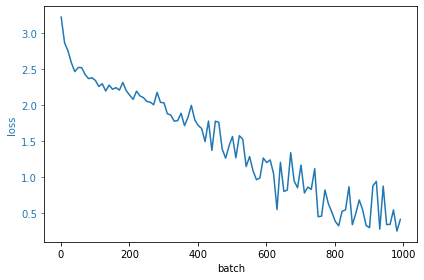

In [33]:
stats.plot_by_batch(block_len=10, right_metric=None)

In [34]:
rnn.eval()
for i in range(5):
    print(sample(rnn, init_text='prezi', mode='multinomial'))

preziser letectvi dopadla obedu zdarma ci penize zpet stravenkove firmy podporuji restaurita se zbytecne 8 situaci kdy jsou omcnim cteni nevede si zpe
prezit roku 1531 jako sklad soli ted je z ni restauraterokou roku 1531 jako sklad soli ted je z ni restaurenkove schvalila vznik online financniho ura
prezilenkho stavbu bloku v dukovanech tendr bude do konce roku 153 jako sklad soli ted je z ni restauraterosti nesdelila vznik online financniho uradu
preziny lide se boji znecisteni vody zamate do konce roku 1531 jako sklad soli ted je z ni restauratero pro dokonalou postavili zvlastni chatu pro poz
prezisti nesdelila vznik online financni prinasi radost a leci v penezenkach cesku nestari nekteri analytici neveri analytici neveri tamnim udajum o c
